# ** [Boosters] Raiffeisen Data Cup. **

Онищенко Елена (Maatkara)

Общий подход:
- Добавляем к каждой транзакции столбец: is_work (если транзакция находится в пределах 0.02 от дома клиента)
- Добавляем к каждой транзакции столбец: is_home (если транзакция находится в пределах 0.02 от работы клиента)
- Обучаем классификатор предсказывающий вероятность (is_home == 1) для транзакции
- Обучаем классификатор предсказывающий вероятность (is_work == 1) для транзакции

Использован Baseline Антона Чикина.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Читаем-train_set,-test_set,-соединяем-в-один-датасет" data-toc-modified-id="Читаем-train_set,-test_set,-соединяем-в-один-датасет-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Читаем train_set, test_set, соединяем в один датасет</a></span><ul class="toc-item"><li><span><a href="#Обрабатываем-дату-транзакции-и-категориальные-признаки" data-toc-modified-id="Обрабатываем-дату-транзакции-и-категориальные-признаки-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обрабатываем дату транзакции и категориальные признаки</a></span></li><li><span><a href="#Фичи-для-даты" data-toc-modified-id="Фичи-для-даты-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Фичи для даты</a></span></li><li><span><a href="#Приводим-адрес-транзакции-для-pos-и-atm-транзакций-к-единообразному-виду" data-toc-modified-id="Приводим-адрес-транзакции-для-pos-и-atm-транзакций-к-единообразному-виду-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Приводим адрес транзакции для pos и atm-транзакций к единообразному виду</a></span></li><li><span><a href="#Генерируем-признаки-is_home,-is_work" data-toc-modified-id="Генерируем-признаки-is_home,-is_work-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Генерируем признаки is_home, is_work</a></span></li><li><span><a href="#Генерируем-категориальный-признак-для-адреса" data-toc-modified-id="Генерируем-категориальный-признак-для-адреса-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Генерируем категориальный признак для адреса</a></span></li><li><span><a href="#Генерируем-несколько-абонентских-фич" data-toc-modified-id="Генерируем-несколько-абонентских-фич-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Генерируем несколько абонентских фич</a></span></li><li><span><a href="#amount---etc." data-toc-modified-id="amount---etc.-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>amount - etc.</a></span></li><li><span><a href="#MCC" data-toc-modified-id="MCC-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>MCC</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вспомогательные-функции-для-оценки-точности-классификатора" data-toc-modified-id="Вспомогательные-функции-для-оценки-точности-классификатора-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вспомогательные функции для оценки точности классификатора</a></span></li><li><span><a href="#Признаки,-на-которых-будем-обучать-модель" data-toc-modified-id="Признаки,-на-которых-будем-обучать-модель-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Признаки, на которых будем обучать модель</a></span></li><li><span><a href="#Создаем-классификаторы" data-toc-modified-id="Создаем-классификаторы-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Создаем классификаторы</a></span></li><li><span><a href="#Обучаем-классификаторы" data-toc-modified-id="Обучаем-классификаторы-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Обучаем классификаторы</a></span></li><li><span><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Подбор гиперпараметров</a></span></li></ul></li><li><span><a href="#Predict" data-toc-modified-id="Predict-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Predict</a></span><ul class="toc-item"><li><span><a href="#Формируем-submission-файл" data-toc-modified-id="Формируем-submission-файл-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Формируем submission-файл</a></span></li></ul></li></ul></div>

In [3]:
import pandas as pd
import numpy as np
import datetime

import xgboost as xgb
import sklearn

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

#import pymorphy2

In [4]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 100)

In [5]:
# Определим типы колонок для экономии памяти
dtypes = {
    'transaction_date': str,
    'atm_address': str,
    'country': str,
    'city': str,
    'amount': np.float32,
    'currency': np.float32,
    'mcc': str,
    'customer_id': str,
    'pos_address': str,
    'atm_address': str,
    'pos_adress_lat': np.float32,
    'pos_adress_lon': np.float32,
    'pos_address_lat': np.float32,
    'pos_address_lon': np.float32,
    'atm_address_lat': np.float32,
    'atm_address_lon': np.float32,
    'home_add_lat': np.float32,
    'home_add_lon': np.float32,
    'work_add_lat': np.float32,
    'work_add_lon': np.float32,
}

# для экономии памяти будем загружать только часть атрибутов транзакций
usecols_train = ['customer_id','transaction_date','amount','country', 'city', 'currency', 'mcc', 'pos_adress_lat', 'pos_adress_lon', 'atm_address_lat', 'atm_address_lon','home_add_lat','home_add_lon','work_add_lat','work_add_lon']
usecols_test = ['customer_id','transaction_date','amount','country', 'city', 'currency', 'mcc', 'pos_address_lat', 'pos_address_lon', 'atm_address_lat', 'atm_address_lon']

## Читаем train_set, test_set, соединяем в один датасет

In [19]:
PTD = '/home/maatkara/2018/ML/DMIA/sport/data/RaiffeisenDataCup/'

In [20]:
PTIN = PTD + 'raw/'
PTR = PTD + 'result/'
PTTMP = PTD + '_tmp/'
PTSUB = PTD + 'sub/'

In [21]:
eps = {}
EPSILON = 0.02
eps['is_home'] = EPSILON
eps['is_work'] = EPSILON


In [22]:
train = pd.read_csv(PTIN + 'train_set.csv', dtype = dtypes, usecols = usecols_train)
train.rename(columns = {'pos_adress_lat': 'pos_address_lat', 'pos_adress_lon': 'pos_address_lon'}, inplace = True)

test = pd.read_csv(PTIN + 'test_set.csv', dtype = dtypes, usecols = usecols_test)
submission = pd.DataFrame(test['customer_id'].unique(), columns = ['_ID_'])

# соединяем test/train в одном DataFrame
train['is_train'] = np.int32(1)
test['is_train'] = np.int32(0)
dt = pd.concat([train, test])

#del train, test

### Обрабатываем дату транзакции и категориальные признаки

In [14]:
dt['city'] = dt['city'].str.lower()

In [15]:
dt['city'] = dt['city'].str.rstrip('.#,! ')

In [16]:
dt.city.fillna('abcd', inplace=True)

In [17]:
# Чистим города
dt.loc[(dt.city.str.contains('moscow')) | (dt.city.str.contains('moskow')) & (~dt.city.str.contains('reg')) & (~dt.city.str.contains('obl')) & (~dt.city.str.contains('ska')), 'city'] = 'moscow'#.value_counts()#[:20]
dt.loc[dt.city.str.contains('moskva') & (~dt.city.str.contains('reg')) & (~dt.city.str.contains('obl')), 'city'] = 'moscow' # .value_counts()#[:20]
dt.loc[dt.city.str.contains('eter') | dt.city.str.contains('spb'), 'city'] = 'st-peterburg'
dt.loc[dt.city.str.contains('dolgoprudnii'), 'city'] = 'dolgoprudnyy'
dt.loc[dt.city.str.contains('volhov'), 'city'] = 'volkhov'



In [ ]:
dt.loc[dt.city.str.contains('himki'), 'city'] ='himki'

In [18]:
d_city = {
    'nizjniy novg' : 'n.novgorod',
    'nizhniy novg' : 'n.novgorod',
    'n novgorod' : 'n.novgorod',
    'nvsib'  : 'novosibirsk',
    'cherepov' : 'cherepovets',
    'mytis' : 'mytishchi',
    'balashi' : 'balashikha',
    'cheljabinsk' : 'chelyabinsk',
    'cherepovec' : 'cherepovets',
    'ekaterinb' : 'ekaterinburg',
    'yekatr' :  'ekaterinburg',
    'chelbn' : 'chelyabinsk',
    'yaroslavl' : 'yaroslavl',
    'rostov na don' : 'rostov-na-don',
    'odincovo' : 'odintsovo',
    'voronej ' : 'voronezh',
    'vsevolojsk' : 'vsevolozhsk',
    'kemerv' : 'kemervo',
    'kommunar' :'kommunarka'
}

In [19]:
for w in (list(d_city.keys())):
    dt.loc[dt.city.str.contains(w) & (~dt.city.str.contains('reg')) & (~dt.city.str.contains('obl')),  'city'] = d_city[w]
    

In [20]:
dt['currency'] = dt['currency'].fillna(-1).astype(np.int32)
dt['mcc'] = dt['mcc'].apply(lambda x: int(x.replace(',', ''))).astype(np.int32)
dt['city_f'] = dt['city'].factorize()[0].astype(np.int32)
dt['country'] = dt['country'].factorize()[0].astype(np.int32)

# удаляем транзакции без даты
dt.drop(dt[dt['transaction_date'].isnull()].index, axis = 0, inplace = True)
dt['transaction_date'] = dt['transaction_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

### Фичи для даты

In [21]:
dt['weekday'] = dt['transaction_date'].dt.weekday.astype(np.int32)
dt['year_day'] = dt['transaction_date'].dt.dayofyear.astype(np.int32)
dt['is_holyday'] = ((dt['weekday'] >= 5)).astype(np.int32)

In [22]:
list_of_holy_add = ['2017-02-23', '2017-02-24','2017-03-08', '2017-05-01', '2017-05-08','2017-05-09','2017-06-12','2017-11-06']

In [23]:
dt['is_holyday'] = dt['is_holyday'] + (dt['transaction_date'].astype(str).isin(list_of_holy_add)).astype(np.int32)

In [24]:
dt['day_bef_holyday'] = 5 - dt['weekday']
dt.loc[dt['day_bef_holyday'] < 0, ['day_bef_holyday']] = 0
d_holy_w = {'2017-02-20' : 3,'2017-02-21' : 2, '2017-02-22' : 1,'2017-03-07' : 1,'2017-03-06' : 2}


In [25]:
dt['transaction_date'].astype(str).isin(d_holy_w.keys())['day_bef_holyday'] = dt['transaction_date'].astype(str).map(d_holy_w)


In [26]:
dt['day_bef_holyday'] = dt['day_bef_holyday'].astype(np.int32)

### Приводим адрес транзакции для pos и atm-транзакций к единообразному виду

In [27]:
dt['is_atm'] = (~dt['atm_address_lat'].isnull()).astype(np.int32)
dt['is_pos'] = (~dt['pos_address_lat'].isnull()).astype(np.int32)

dt['address_lat'] = dt['atm_address_lat'].fillna(0) + dt['pos_address_lat'].fillna(0)
dt['address_lon'] = dt['atm_address_lon'].fillna(0) + dt['pos_address_lon'].fillna(0)

dt.drop(['atm_address_lat','atm_address_lon','pos_address_lat','pos_address_lon'], axis = 1, inplace = True)

# удалим транзакции без адреса
dt.drop(dt[((dt['address_lon'] == 0) & (dt['address_lon'] == 0))].index, axis = 0, inplace = True)

### Генерируем признаки is_home, is_work

In [28]:
# eps = EPSILON
lat = dt['home_add_lat'] - dt['address_lat']
lon = dt['home_add_lon'] - dt['address_lon']
#MX добавим расстояние от места траты до дома и до работы
dt['l_home'] = np.sqrt((lat ** 2) + (lon ** 2))


dt['is_home_0'] = (dt['l_home'] <= EPSILON).astype(np.int32) #MX
dt['is_home'] = (dt['l_home'] <= eps['is_home']).astype(np.int32) #MX
dt['has_home'] = (~dt['home_add_lon'].isnull()).astype(np.int32)


lat = dt['work_add_lat'] - dt['address_lat']
lon = dt['work_add_lon'] - dt['address_lon']

#MX добавим расстояние от места траты до дома и до работы
dt['l_work'] = np.sqrt((lat ** 2) + (lon ** 2))

dt['is_work_0'] = ( dt['l_work'] <= EPSILON).astype(np.int32)
dt['is_work'] = ( dt['l_work'] <= eps['is_work']).astype(np.int32)
dt['has_work'] = (~dt['work_add_lon'].isnull()).astype(np.int32)

dt.drop(['l_home', 'l_work'], axis = 1, inplace = True)
# dt.drop(['work_add_lat','work_add_lon','home_add_lat','home_add_lon'], axis = 1, inplace = True)

### Генерируем категориальный признак для адреса

In [32]:
dt['address'] = dt['address_lat'].apply(lambda x: "%.02f" % x) + ';' + dt['address_lon'].apply(lambda x: "%.02f" % x)
dt['address'] = dt['address'].factorize()[0].astype(np.int32)

### Генерируем несколько абонентских фич

In [34]:
# количество транзакций каждого клиента
dt = dt.merge(dt.groupby('customer_id')['amount'].count().reset_index(name = 'tx'), how = 'left')
dt['tx'] = dt['tx'].astype(np.int32) 

dt = dt.merge(dt.groupby(['customer_id','address'])['amount'].count().reset_index(name = 'tx_cust_addr'), how = 'left')
dt['tx_cust_addr'] = dt['tx_cust_addr'].astype(np.int32) # кол-во транзакций каждого клиента в каждой точке 

# какая часть транзакций клиента приходится на данный адрес
dt['ratio1'] = dt['tx_cust_addr'] / dt['tx']

In [35]:

dt = dt.merge(dt.groupby(['customer_id','city_f'])['amount'].count().reset_index(name = 'city_cust_addr'), how = 'left')
dt['city_cust_addr'] = dt['city_cust_addr'].astype(np.int32) # кол-во транзакций каждого клиента в каждоv городе 

# какая часть транзакций клиента приходится на данный адрес
dt['ratio3'] = dt['city_cust_addr'] / dt['tx']

In [36]:
dt= dt.merge(dt.groupby('customer_id')['address_lat'].median().reset_index(name = 'tx_cust_median_lat'), how = 'left')
dt= dt.merge(dt.groupby('customer_id')['address_lon'].median().reset_index(name = 'tx_cust_median_lon'), how = 'left')


In [37]:
dt= dt.merge(dt.groupby('customer_id')['address_lat'].mean().reset_index(name = 'tx_cust_mean_lat'), how = 'left')
dt= dt.merge(dt.groupby('customer_id')['address_lon'].mean().reset_index(name = 'tx_cust_mean_lon'), how = 'left')


In [38]:
# eps = EPSILON
lat_ = dt['tx_cust_median_lat'] - dt['address_lat']
lon_ = dt['tx_cust_median_lon'] - dt['address_lon']

#MX добавим расстояние от места траты до медины трат по каждому клиенту
dt['l_median'] = np.sqrt((lat_ ** 2) + (lon_ ** 2))
dt['is_median'] = (dt['l_median'] <= EPSILON).astype(np.int32) #MX
# dt.drop(['work_add_lat','work_add_lon','home_add_lat','home_add_lon'], axis = 1, inplace = True)

In [39]:
# eps = EPSILON
lat_ = dt['tx_cust_mean_lat'] - dt['address_lat']
lon_ = dt['tx_cust_mean_lon'] - dt['address_lon']

#MX добавим расстояние от места траты до медины трат по каждому клиенту
dt['l_mean'] = np.sqrt((lat_ ** 2) + (lon_ ** 2))
dt['is_mean'] = (dt['l_mean'] <= EPSILON).astype(np.int32) #MX
# dt.drop(['work_add_lat','work_add_lon','home_add_lat','home_add_lon'], axis = 1, inplace = True)

### amount - etc.

In [46]:
d_curs = {643 : 0,
          978 : np.log(63.68),
          784 : np.log(16.3),
          840 : np.log(59.94)}

In [47]:
dt.currency.map(d_curs).value_counts()

0.000000    2168407
4.153871       2192
4.093344       1866
2.791165          7
Name: currency, dtype: int64

In [48]:
dt['amount_r'] = dt.amount + dt.currency.map(d_curs)

In [49]:
dt['amount_value'] = 10 ** dt['amount_r']

In [50]:
# сумма транзакций каждого клиента
dt = dt.merge(dt.groupby('customer_id')['amount_value'].sum().reset_index(name = 'sum_tr'), how = 'left')

dt = dt.merge(dt.groupby(['customer_id','address'])['amount_value'].sum().reset_index(name = 'sum_tr_cust_addr'), how = 'left')
 
#какая часть суммы транзакций клиента приходится на данный адрес
dt['ratio2'] = dt['sum_tr_cust_addr'] / dt['sum_tr'].astype(np.float32)


### MCC



In [59]:
mcc_df = pd.read_csv(PTIN + 'mcc_t.csv', sep='\t')
mcc_df.fillna('абс', inplace=True)

In [60]:
dt['mcc_gr'] = dt['mcc'].map(mcc_df[['MCC', 'Группа']].set_index('MCC')['Группа'].to_dict())
dt['mcc_gr_le'] = dt['mcc_gr'].factorize()[0].astype(np.int32)

In [61]:
dt['is_shop'] = dt['mcc_gr'].str.lower().str.contains('магазин').astype(np.int32)

## Обучение

### Вспомогательные функции для оценки точности классификатора

In [65]:
def _best(x):
    """
    ret - массив координат адресов, наиболее вероятных (по клиенту) (home/work)
    """
    ret = None
    for col in ys:
        pred = ('pred:%s' % col)
        if pred in x:
            i = (x[pred].idxmax())
            cols = [pred,'address_lat','address_lon']
            if col in x:
                col_0 = col + '_0'
                cols.append(col)
                cols.append(col_0)
            tmp = x.loc[i,cols]
            tmp.rename({
                'address_lat':'%s:add_lat' % col,
                'address_lon':'%s:add_lon' % col,
            }, inplace = True)
            if ret is None:
                ret = tmp
            else:
                ret = pd.concat([ret, tmp])
    return ret

In [66]:
def predict_proba(dt, xs, ys=['is_home', 'is_work']):
    for col in ys:
        pred = ('pred:%s' % col)
        dt[pred] = model[col].predict_proba(dt[xs[col]])[:,1]
    return dt.groupby('customer_id').apply(_best).reset_index()

In [67]:
def score(dt, xs, ys=['is_home', 'is_work']):
    dt_ret = predict_proba(dt, xs, ys)
    #print(dt_ret.head())
    mean = 0.0
    for col in ys:
        col_0 = col + '_0'
        col_mean = dt_ret[col_0].mean()
        mean += col_mean
    if len(ys) == 2:
        mean = mean / len(ys)
    return mean

In [68]:
def mean_target_enc(train_df, valid_df, col_tag, cat_feats, n_splits=3, random_state=0, shuffle=True, alpha=10): #, skf=skf):
    
    vdf = []
    feats_new = []
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    y_train = train_df[col_tag]
    glob_mean = y_train.mean()
    #print('glob_mean=', glob_mean)
    #train_df = pd.concat([train_df, pd.Series(y_train, name='y')], axis=1)
    new_train_df = train_df.copy()
    new_valid_df = valid_df.copy()
    # print(new_valid_df.head())
    #for col in cat_feats:
        #new_train_df[col + '_mean_target'] = [glob_mean for _ in range(new_train_df.shape[0])]
    
    cust_train = new_train_df.groupby('customer_id')[col_tag.replace('is_','has_')].max()
    cust_train = cust_train[cust_train > 0].index
    
    for train_idx, valid_idx in kf.split(cust_train):
        train_df_cv = pd.DataFrame(cust_train[train_idx], columns = ['customer_id']).merge(new_train_df, how = 'left')
        valid_df_cv = pd.DataFrame(cust_train[valid_idx], columns = ['customer_id']).merge(new_train_df, how = 'left')
        
        for col in cat_feats:
            feat_new = col + '_mean_target'
            
            k = train_df_cv.groupby(col).size()
            
            means = (train_df_cv.groupby(col)[col_tag].mean() * k + glob_mean * alpha) / (k + alpha)
            means_reg = valid_df_cv[col].map(means) # (means * k + glob_mean * alpha) / (k + alpha)
            valid_df_cv[feat_new] = means_reg.fillna(glob_mean)
            
        vdf.append(valid_df_cv)
    
    new_train_df = pd.concat(vdf)
    
    for col in cat_feats:
        feat_new = col + '_mean_target'
        feats_new.append(feat_new)
        
        k = train_df.groupby(col).size() # кол-во значений
        
        means = (train_df.groupby(col)[col_tag].mean() * k + glob_mean * alpha) / (k + alpha)
        means_reg = valid_df[col].map(means) # (means * k + glob_mean * alpha) / (k + alpha)
        new_valid_df[feat_new] = means_reg.fillna(glob_mean)
        #print(k)
        
    #new_valid_df.drop(cat_feats, axis=1, inplace=True)
    
    return new_train_df, new_valid_df, feats_new

### Признаки, на которых будем обучать модель

In [90]:
xs_is_home = ['amount_r', 'weekday','year_day','mcc','is_atm','is_pos', 'ratio1', 'address_lat', 'address_lon', 'tx_cust_median_lat', 'tx_cust_median_lon', 'city_f'] #''city',   ,'ratio2'#, 'l_mean', 'mcc_gr_le','country', 'ratio2'- 'is_holyday','currency'
xs_is_work =  xs_is_home #+ ['is_shop'] #  +['is_holyday']
xs0 = {
    'is_home': xs_is_home, #  + ['tx_cust_median_lat'] + ['tx_cust_median_lon'],
    'is_work': xs_is_work # + ['ratio3']
}

ys = ['is_home', 'is_work']

### Создаем классификаторы


In [73]:
params_h = {}

In [105]:
params_w = {
    #'learning_rate': 0.1,
    #'colsample_bytree': 0.65,
    #'gamma': 0.18,
    #'silent' : 50
    'max_depth': 8,
    'min_child_weight': 6,
    #'subsample': 1.0,
    #'reg_alpha': 0.00030293609068908023,
    #'reg_lambda': 0.005864849614546989,
}

In [108]:
model0 = {
    'is_home': xgb.XGBClassifier(**params_h, n_estimators = 1000, n_jobs = -1),
    'is_work': xgb.XGBClassifier(**params_w, n_estimators = 100, n_jobs = -1),
}

### Обучаем классификаторы

In [109]:
model = {}
col_lat_add = False
mean = 0.
mean_test_kf = []
mean_t_kf = []
cat_feats = ['day_bef_holyday'] #, 'city_f'] # ['address']# ['mcc_gr_le'] #['is_shop']
xsd = {}
mean_test_d = {}

kf = KFold(n_splits=3, shuffle=True, random_state=100)
#col_mtarg = ['is_mean', 'is_median']
# последовательно обучаем два классификатора


for col in ['is_home','is_work']: #'is_home',
    
    print ("Training:", col)
    print ("Test accuracy XGB:")
    #выберем для обучение транзакции только тех клиентов из train, у которых хоть в одной транзакции указано место работы/жительства
    cust_train = dt[dt['is_train'] == 1].groupby('customer_id')[col.replace('is_','has_')].max()
    cust_train = cust_train[cust_train > 0].index
    
    #разобъем train на train/valid для валидации
    for train_index, test_index in kf.split(cust_train):
    
        train = pd.DataFrame(cust_train[train_index], columns = ['customer_id']).merge(dt, how = 'left')
        valid = pd.DataFrame(cust_train[test_index], columns = ['customer_id']).merge(dt, how = 'left')

              
        if len(cat_feats)>0:
            # Кодирование категориальных средним таргет
            train_new, valid_new, feats_new = mean_target_enc(train, valid, col, cat_feats, alpha=10)
            xs = xs0[col] + feats_new
        else:
            train_new, valid_new = train, valid
            xs = xs0[col]
            
        
        clf = sklearn.base.clone(model0[col])
        clf.fit(train_new[xs], train_new[col],\
                eval_metric = 'logloss',\
                eval_set = [(train_new[xs], train_new[col]),\
                            (valid_new[xs], valid_new[col])], verbose=0) 
        
        xsd[col] = xs
        model[col] = clf
        col_0 = col + '_0'
        #print(col_0)
        mean_test_k = score(valid_new, xsd, ys=[col])
        mean_t_k = score(train_new, xsd, ys=[col])
        mean_test_kf.append(mean_test_k)
        mean_t_kf.append(mean_t_k)
        #print (mean_test_k )
        model = {}
    
    
    print (mean_test_kf)   
    mean_test = np.mean(mean_test_kf)
    mean_t = np.mean(mean_t_kf)
    std_test = np.std(mean_test_kf)
    mean_test_d[col] = mean_test_kf
    mean += mean_test 
    mean_test_kf = []
    mean_t_kf = []
    mean_l =[]
    
    
    print (60*'-')
    #print ("Mean Train accuracy XGB:", mean_t)
    print ("Mean Test accuracy XGB :", mean_test, " std:", std_test)
    print (60*'-')
    print ()

    
for i in range(3):
    mean_l.append((mean_test_d["is_home"][i] + mean_test_d["is_work"][i])/ 2)
     
print ("Test accuracy XGB min:", np.min(mean_l)) 
print()
print ("Test accuracy XGB:", mean / 2)   

# Baseline
# is_home
# Train accuracy: 0.37755555555555553
# Test accuracy: 0.376
#
# is_work
#Train accuracy: 0.26066350710900477
# Test accuracy: 0.24806201550387597

# 

Training: is_home
Test accuracy XGB:
[0.41571685662867425, 0.4083408340834083, 0.40504050405040504]
------------------------------------------------------------
Mean Test accuracy XGB : 0.4096993982541625  std: 0.00446321248642139
------------------------------------------------------------

Training: is_work
Test accuracy XGB:
[0.31046511627906975, 0.29261198371146013, 0.3036649214659686]
------------------------------------------------------------
Mean Test accuracy XGB : 0.3022473404854995  std: 0.007357116169455783
------------------------------------------------------------

Test accuracy XGB min: 0.35047640889743426

Test accuracy XGB: 0.35597336936983104


### Подбор гиперпараметров

In [83]:
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [84]:
def score_hp(params):
    from sklearn.metrics import log_loss
    print("Training with params:")
    print(params)
    params['max_depth'] = int(params['max_depth'])
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    model_ = xgb.train(params, dtrain, params['num_round'])
    predictions = model_.predict(dvalid)#.reshape((X_test.shape[0], 2))
    score_ = log_loss(y_test, predictions)
    print("\tScore {0}\n\n".format(score_))
    return {'loss': score_, 'status': STATUS_OK}

In [92]:
def optimize(trials):
    space = {
        'num_round': 100,
        #'learning_rate': 0.1,
        'learning_rate': hp.quniform('eta', 0.01, 0.1, 0.005),
        'max_depth': hp.quniform('max_depth', 3, 17, 1),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'subsample': hp.quniform('subsample', 0.6, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.05, 1, 0.01),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 1, 0.05),
        'reg_lambda' : hp.loguniform('reg_lambda', np.log( 1e-5 ), np.log( 100 )),
        'reg_alpha' : hp.loguniform('reg_alpha',np.log( 1e-5 ), np.log( 100 )),
        #'num_class' : 2,
        'eval_metric': 'logloss',
        'objective': 'binary:logistic',
        'nthread' : 8,
        'silent' : 0
        }
    
    best = fmin(score_hp, space, algo=tpe.suggest, trials=trials, max_evals=50)
    return best

In [93]:
model = {}

# последовательно обучаем два классификатора
for col in ['is_work']:#,'is_work']:
    
    xs = xs0[col]
    #выберем для обучение транзакции только тех клиентов из train, у которых хоть в одной транзакции указано место работы/жительства
    cust_train = dt[dt['is_train'] == 1].groupby('customer_id')[col.replace('is_','has_')].max()
    cust_train = cust_train[cust_train > 0].index
    
    #разобъем train на train/valid для валидации
    cust_train, cust_valid = train_test_split(cust_train, test_size = 0.1, shuffle = True, random_state = 2)
    
    train = pd.DataFrame(cust_train, columns = ['customer_id']).merge(dt, how = 'left')
    valid = pd.DataFrame(cust_valid, columns = ['customer_id']).merge(dt, how = 'left')
    
    X_train, y_train = train[xs], train[col]
    X_test, y_test = valid[xs], valid[col]
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    
    print ("Training:", col)
    
    
    trials = Trials()
    best_params = optimize(trials)
    best_params
    
    print ()



Training: is_work
Training with params:
{'colsample_bytree': 0.7000000000000001, 'eval_metric': 'logloss', 'gamma': 0.66, 'learning_rate': 0.02, 'max_depth': 8.0, 'min_child_weight': 6.0, 'nthread': 8, 'num_round': 100, 'objective': 'binary:logistic', 'reg_alpha': 0.31724604801755757, 'reg_lambda': 0.011883334569878596, 'silent': 0, 'subsample': 0.9}
	Score 0.3829840672711827


Training with params:
{'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'gamma': 0.61, 'learning_rate': 0.035, 'max_depth': 5.0, 'min_child_weight': 9.0, 'nthread': 8, 'num_round': 100, 'objective': 'binary:logistic', 'reg_alpha': 0.0007077133383460728, 'reg_lambda': 1.061120725039018e-05, 'silent': 0, 'subsample': 0.8}
	Score 0.3764907744499563


Training with params:
{'colsample_bytree': 0.65, 'eval_metric': 'logloss', 'gamma': 0.72, 'learning_rate': 0.1, 'max_depth': 4.0, 'min_child_weight': 3.0, 'nthread': 8, 'num_round': 100, 'objective': 'binary:logistic', 'reg_alpha': 0.39464296265258825, 'reg_lambda': 

	Score 0.3507788686497058


Training with params:
{'colsample_bytree': 0.75, 'eval_metric': 'logloss', 'gamma': 0.84, 'learning_rate': 0.085, 'max_depth': 10.0, 'min_child_weight': 5.0, 'nthread': 8, 'num_round': 100, 'objective': 'binary:logistic', 'reg_alpha': 42.70739963108683, 'reg_lambda': 7.433721220402864e-05, 'silent': 0, 'subsample': 0.75}
	Score 0.35225698388462295


Training with params:
{'colsample_bytree': 0.75, 'eval_metric': 'logloss', 'gamma': 0.98, 'learning_rate': 0.085, 'max_depth': 9.0, 'min_child_weight': 7.0, 'nthread': 8, 'num_round': 100, 'objective': 'binary:logistic', 'reg_alpha': 94.28008146924297, 'reg_lambda': 3.716391339795854e-05, 'silent': 0, 'subsample': 0.75}
	Score 0.35565188691040583


Training with params:
{'colsample_bytree': 0.75, 'eval_metric': 'logloss', 'gamma': 0.8200000000000001, 'learning_rate': 0.095, 'max_depth': 7.0, 'min_child_weight': 5.0, 'nthread': 8, 'num_round': 100, 'objective': 'binary:logistic', 'reg_alpha': 85.19151320218626, 'r

	Score 0.3615444396399445


Training with params:
{'colsample_bytree': 0.7000000000000001, 'eval_metric': 'logloss', 'gamma': 0.33, 'learning_rate': 0.095, 'max_depth': 15.0, 'min_child_weight': 7.0, 'nthread': 8, 'num_round': 100, 'objective': 'binary:logistic', 'reg_alpha': 1.5810452135079172, 'reg_lambda': 0.0004959092125149836, 'silent': 0, 'subsample': 0.8500000000000001}
	Score 0.37848656996609026


Training with params:
{'colsample_bytree': 0.8500000000000001, 'eval_metric': 'logloss', 'gamma': 0.58, 'learning_rate': 0.07, 'max_depth': 7.0, 'min_child_weight': 4.0, 'nthread': 8, 'num_round': 100, 'objective': 'binary:logistic', 'reg_alpha': 0.007932154815792939, 'reg_lambda': 0.02792877885629195, 'silent': 0, 'subsample': 0.65}
	Score 0.356790632522252


Training with params:
{'colsample_bytree': 0.6000000000000001, 'eval_metric': 'logloss', 'gamma': 0.51, 'learning_rate': 0.03, 'max_depth': 13.0, 'min_child_weight': 5.0, 'nthread': 8, 'num_round': 100, 'objective': 'binary:logi

In [94]:
best_params

{'colsample_bytree': 0.65,
 'eta': 0.085,
 'gamma': 0.87,
 'max_depth': 10.0,
 'min_child_weight': 7.0,
 'reg_alpha': 46.94287527192864,
 'reg_lambda': 1.2681376842126568e-05,
 'subsample': 0.75}

In [95]:
trials.best_trial

{'book_time': datetime.datetime(2018, 3, 23, 20, 22, 19, 267000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'colsample_bytree': [22],
   'eta': [22],
   'gamma': [22],
   'max_depth': [22],
   'min_child_weight': [22],
   'reg_alpha': [22],
   'reg_lambda': [22],
   'subsample': [22]},
  'tid': 22,
  'vals': {'colsample_bytree': [0.65],
   'eta': [0.085],
   'gamma': [0.87],
   'max_depth': [10.0],
   'min_child_weight': [7.0],
   'reg_alpha': [46.94287527192864],
   'reg_lambda': [1.2681376842126568e-05],
   'subsample': [0.75]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2018, 3, 23, 20, 22, 29, 688000),
 'result': {'loss': 0.3507788686497058, 'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 22,
 'version': 0}

## Predict

In [110]:
model = {}

cust_test = dt[dt['is_train'] == 0]['customer_id'].unique()
cust_train = dt[dt['is_train'] == 1]['customer_id'].unique()


train = pd.DataFrame(cust_train, columns = ['customer_id']).merge(dt, how = 'left')
test = pd.DataFrame(cust_test, columns = ['customer_id']).merge(dt, how = 'left')

for col in ['is_home','is_work']:
    
    if  col_lat_add:
        col_lat = col.replace('is_', '') + '_add_lat'#home_add_lat	home_add_lon	
        col_lon = col.replace('is_', '') + '_add_lon'
    else:
        col_lat, col_lon = [], []
            
    if len(cat_feats)>0:
            # Кодирование категориальных средним таргет
        train_new, test_new, feats_new = mean_target_enc(train, test, col, cat_feats, alpha=10)
        xs = xs0[col] + feats_new # + [col_lat] + [col_lon]
    else:
        train_new, valid_new = train, valid
        xs = xs0[col]# + [col_lat] + [col_lon]        
    print ("Training:", col)
    
    clf = sklearn.base.clone(model0[col])
    clf.fit(train_new[xs], train_new[col],eval_metric = 'logloss', verbose=50) # early_stopping_rounds=10,
      
    model[col] = clf

Training: is_home
Training: is_work


In [113]:
def my_plot_importance(booster, figsize, **kwargs):
    from xgboost import plot_importance
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)


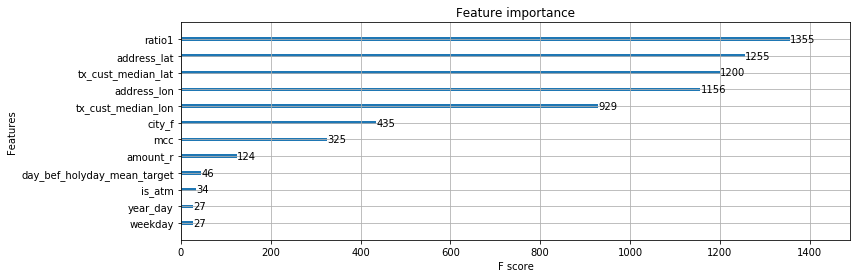

In [114]:
my_plot_importance(model['is_home'], figsize=(12, 4))

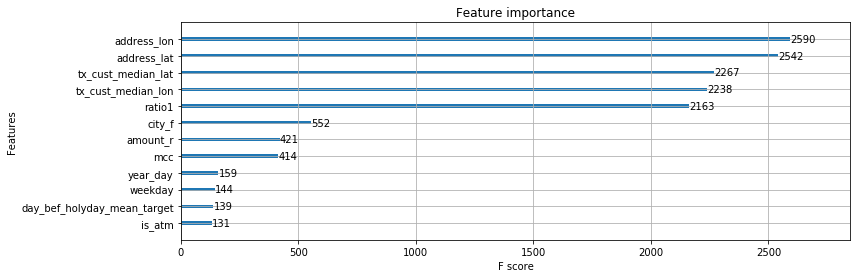

In [115]:
my_plot_importance(model['is_work'], figsize=(12, 4))

In [116]:
test_ = predict_proba(test_new, xsd)
test_.rename(columns = {
        'customer_id':'_ID_',
        'is_home:add_lat': '_HOME_LAT_',
        'is_home:add_lon': '_HOME_LON_',
        'is_work:add_lat': '_WORK_LAT_',
        'is_work:add_lon': '_WORK_LON_'}, inplace = True)
test_ = test_[['_ID_', '_WORK_LAT_', '_WORK_LON_', '_HOME_LAT_', '_HOME_LON_']]

In [122]:
test_.loc[test_._WORK_LAT_.isnull(), :]

,_ID_,_WORK_LAT_,_WORK_LON_,_HOME_LAT_,_HOME_LON_


In [125]:
test_.median()

_WORK_LAT_    55.774603
_WORK_LON_    37.617001
_HOME_LAT_    55.802303
_HOME_LON_    37.615240
dtype: float64

### Формируем submission-файл

In [126]:
n_sub = 8

In [127]:
# Заполняем пропуски
#submission = submission.merge(test, how = 'left').fillna(0)
submission = submission.merge(test_, how = 'left').fillna(test_.median())
# Пишем файл submission
submission.to_csv(PTSUB + 'Sub_' + str(n_sub) + '.csv', index = False)